In [29]:
import numpy as np
import pandas as pd

# Exercise 6.1

a. Show empirically that the information limit of 2 prediction bits per parameter also holds for nearest neighbors.

In [284]:
from sklearn.neighbors import KNeighborsClassifier

"""
For each individual function you generated, you count how many points you have to keep to still perfectly test on train.
I used all 16 function in of 2 variables, 32 functions of 4 dimensions, 64 of 8 dimensions. To get to the amount of points
you have to memorize, I average over all points I had to keep for this chosen dimensionality.

d=2: n_full=4, Avg. req. points for memorization n_avg=2.62, n_full/n_avg=1.5238095238095237
d=4: n_full=16, Avg. req. points for memorization n_avg=9.40, n_full/n_avg=1.702127659574468
d=8: n_full=256, Avg. req. points for memorization n_avg=131.60, n_full/n_avg=1.9452887537993921 # I actually got very close to this!!
"""

np.random.seed(0)

def get_avg_points(funcs, n_full):
    avg_mem_size = 0
    for function in funcs:
        for n_pts_to_train_on in range(1, n_full):
            indices = np.random.choice(range(n_full), n_pts_to_train_on, replace=False)
            X_train = function[indices, :-1]
            y_train = function[indices, -1]
            X_test = np.delete(function, indices, axis=0)[:, :-1]
            y_test = np.delete(function, indices, axis=0)[:, -1]
            knn = KNeighborsClassifier(n_neighbors=1)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy == 1.0:
                avg_mem_size += n_pts_to_train_on
                # break
    avg_mem_size /= len(funcs)
    return avg_mem_size

def run_experiment(dimensions=[2, 4, 8], n_classes=2):
    results = []
    for d in dimensions:
        n_full = 2 ** d
        function_limit = 2 ** 8 #d * 8 # Arbitrary limit to keep the number of functions reasonable
        # X = np.array([[int(x) for x in list(format(i, f'0{d}b'))] for i in range(n_full)]) # Generate all possible binary inputs of length d --> n_full = 2^d

        # X should be a random binary dataset of size n_full x d
        X = np.random.randint(0, 2, size=(n_full, d))

        # There are n_classes^n_full possible labelings. Since this number can be huge, we generate a random subset of size min(n_classes^n_full, function_limit)
        y = np.random.randint(0, n_classes, size=(n_classes ** n_full if n_classes ** n_full <= function_limit else function_limit, n_full))
        functions = [np.hstack((X, y[i].reshape(-1, 1))) for i in range(n_classes ** n_full if n_classes ** n_full <= function_limit else function_limit)] # Combine X with each possible labeling
        if 2 ** n_full > function_limit:
            print(f"d = {d}: Theoretical number of functions {n_classes ** n_full} was limited to function limit {function_limit}")
        else:
            print(f"d = {d}: Number of functions: {len(functions)}")
        n_avg = get_avg_points(functions, n_full)
        print(f"n/d = {n_full/d}")
        results.append({"d": d, "n_full": n_full, "n_functions": len(functions), "n_avg": n_avg, "n_full/n_avg": n_full/n_avg})
    return results

part_a = pd.DataFrame(run_experiment(dimensions=[1, 2, 3, 4], n_classes=2))
print(part_a.to_string(index=False))

d = 1: Number of functions: 4
n/d = 2.0
d = 2: Number of functions: 16
n/d = 2.0
d = 3: Number of functions: 256
n/d = 2.6666666666666665
d = 4: Number of functions: 65536
n/d = 4.0
 d  n_full  n_functions     n_avg  n_full/n_avg
 1       2            4  0.750000      2.666667
 2       4           16  1.062500      3.764706
 3       8          256  5.875000      1.361702
 4      16        65536 14.109161      1.134015


b. Extend your experiments to multi-class classification.

In [253]:
part_b = pd.DataFrame(run_experiment(n_classes=3))
print(part_b.to_string(index=False))

Number of functions: 81
Theoretical number of functions 43046721 was limited to function limit 256
Theoretical number of functions 139008452377144732764939786789661303114218850808529137991604824430036072629766435941001769154109609521811665540548899435521 was limited to function limit 256
 d  n_full  n_functions      n_avg  n_full/n_avg
 2       4           81   0.938272      4.263158
 4      16          256   6.347656      2.520615
 8     256          256 106.371094      2.406669


# Exercise 6.2

### a.

Implement a program that automatically creates a set of if-then clauses from the training table of a binary dataset of your choice. Implement different strategies to minimize the number of if-then clauses. Document your strategies, the number of resulting conditional clauses, and the accuracy achieved.

if (worst concave points <= 0.142) and (worst area <= 957.45) and (worst perimeter <= 107.75) and (worst fractal dimension > 0.055) and (mean concavity <= 0.141) and (area error <= 48.975) and (smoothness error > 0.003) and (worst texture <= 32.83) then class: benign (proba: 100.0%) | based on 239 samples
if (worst concave points > 0.142) and (worst area > 729.55) and (area error > 14.18) and (worst concavity > 0.203) and (mean texture > 15.37) then class: malignant (proba: 100.0%) | based on 131 samples
if (worst concave points <= 0.142) and (worst area <= 957.45) and (worst perimeter <= 107.75) and (worst fractal dimension > 0.055) and (mean concavity <= 0.141) and (area error <= 48.975) and (smoothness error > 0.003) and (worst texture > 32.83) and (worst texture > 33.805) then class: benign (proba: 100.0%) | based on 16 samples
if (worst concave points <= 0.142) and (worst area <= 957.45) and (worst perimeter > 107.75) and (mean perimeter > 91.92) and (concave points error <= 0.016

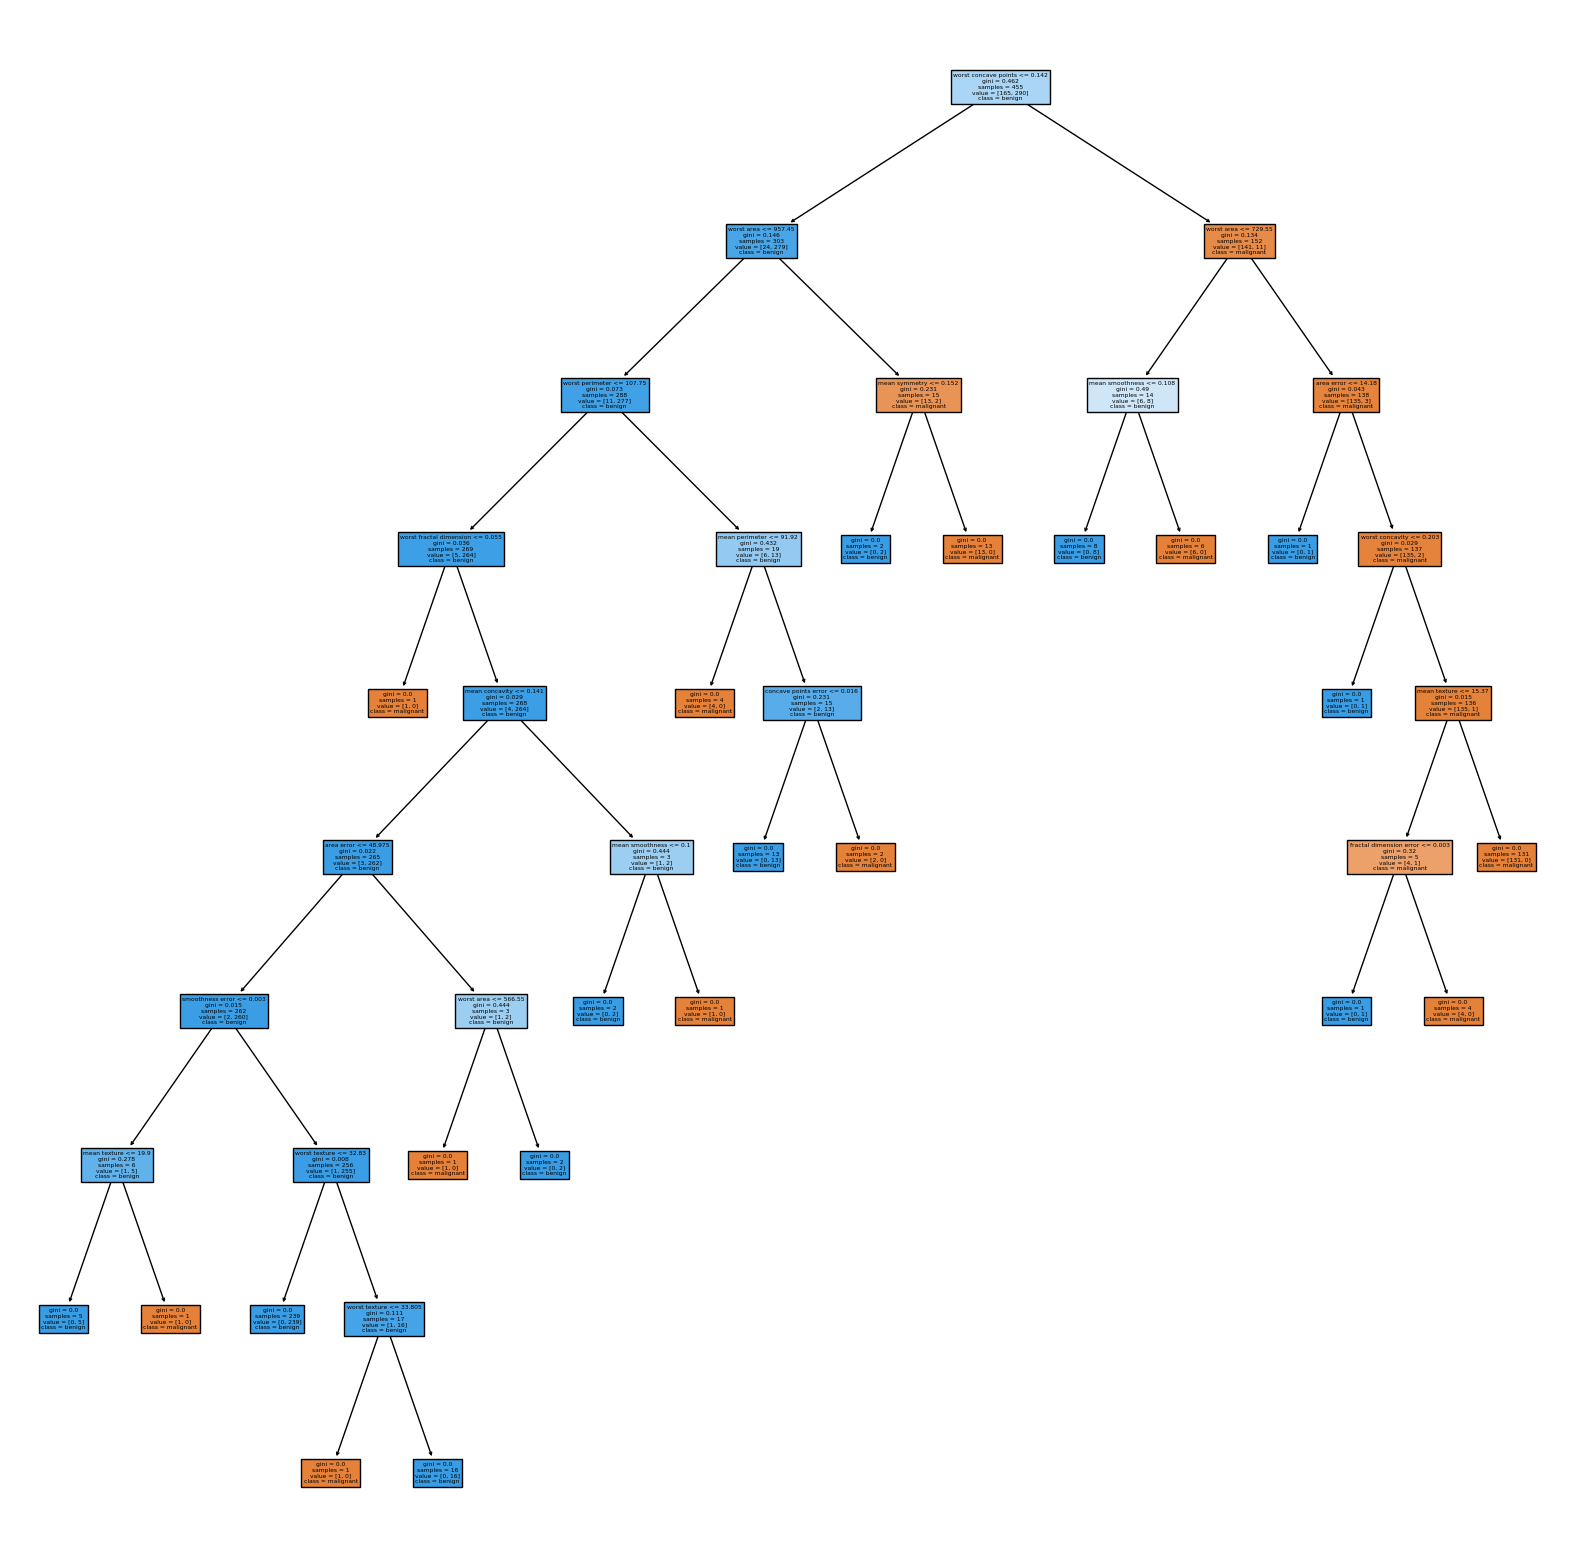

In [97]:
from sklearn.tree import DecisionTreeClassifier, _tree, plot_tree
from sklearn.datasets import load_breast_cancer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


dataset = load_breast_cancer()
X = dataset.data
y = dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


clf = DecisionTreeClassifier(random_state=0, criterion='gini')
clf.fit(X_train, y_train)

# Get the tree as a list of if-then clauses. From: https://stackoverflow.com/a/66369924
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


# Get number of non-leaf nodes
def evaluate_and_plot_decision_tree(clf, X_test, y_test, feature_names=None, target_names=None, show_results=False, print_stats=True):
    
    if show_results:
        rules = get_rules(clf, dataset.feature_names, dataset.target_names)
        for r in rules:
            print(r)
        print("")

    n_nodes = clf.tree_.node_count
    num_leaf_nodes = np.sum(clf.tree_.children_left == -1)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)

    if print_stats:
        print(f"Criterion: {clf.criterion}\n")
        print(f"Number of nodes in the decision tree: {n_nodes}")
        print(f"Number of non-leaf nodes (if-then clauses): {n_nodes - num_leaf_nodes}")
        print(f"Height of tree: {clf.tree_.max_depth}")
        print(f"\nAccuracy: {acc * 100:.2f}%")

    # Print decision tree
    if show_results:
        plt.figure(figsize=(20, 20))
        plot_tree(clf, filled=True, feature_names=feature_names, class_names=target_names)
        plt.show()

    return n_nodes, n_nodes - num_leaf_nodes, clf.tree_.max_depth, acc

_ = evaluate_and_plot_decision_tree(clf, X_test, y_test, dataset.feature_names, dataset.target_names, show_results=True)


Since a binary decision tree essentially learns a set of if-then clauses (decisions), I first used a decision tree classifier on the breast cancer binary classification dataset (benign or malignant) included in Scikit-learn. This dataset contains $569$ samples total ($212$ malignant, $357$ benign) with dimensionality $30$. I experimented with 2 different criterion to measure the reduction in uncertainty of a certain clause: Gini impurity and Shannon entropy. Note that Scikit-learn also offers a log-loss criterion, but this is mathematically equivalent to Shannon entropy since the predicted class probabilities within each leaf are constant. 

While we are familiar with Shannon entropy, Gini impurity measures how often a randomly chosen datapoint from the data would be incorrectly classified if it was randomly labeled according to the distribution of labels in the subset . It is defined as:

$$
G = 1 - \sum_{i=1}^{n} p_i^2 
$$

where $p_i$ is the probability of picking a datapoint of class $i$. As such, it is minimized when all of the datapoints are of the same class.

Shannon entropy:
- Number of nodes in the decision tree: $33$
- Number of non-leaf nodes (if-then clauses): $16$
- Height of tree: $8$
- Accuracy: $92.98\%$

Gini impurity:
- Number of nodes in the decision tree: $43$
- Number of non-leaf nodes (if-then clauses): $21$
- Height of tree: $9$
- Accuracy: $91.23\%$

Using a standard $80/20$ train/test split, the decision tree classifier achieved $92.98\%$ accuracy using Shannon entropy and $91.23\%$ accuracy using Gini impurity. The decision tree classifier using Shannon entropy resulted in a smaller number of if-then clauses and a shorter tree, hinting that the Gini tree was slightly more overfit to the training set. 

### b.

Use the algorithms developed in (a) on different datasets. Again, observe how your choices make a difference.

In [94]:
weather = pd.read_csv('./data/weatherAUS.csv')

# Drop rows where the labelis missing (2623 rows)
weather.dropna(subset=['RainTomorrow'], inplace=True)

# Create training and test splits
X = weather.drop('RainTomorrow', axis=1)
y = weather['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fill missing values
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
category_cols = X_train.select_dtypes(include=['object']).columns
X_train[numerical_cols] = X_train[numerical_cols].fillna(X_train[numerical_cols].mean())
X_train[category_cols] = X_train[category_cols].astype('category').apply(lambda x: x.cat.codes)
X_test[numerical_cols] = X_test[numerical_cols].fillna(X_test[numerical_cols].mean())
X_test[category_cols] = X_test[category_cols].astype('category').apply(lambda x: x.cat.codes)


clf_weather = DecisionTreeClassifier(random_state=0, criterion='entropy')
clf_weather.fit(X_train, y_train)

_ = evaluate_and_plot_decision_tree(clf_weather, X_test, y_test, X.columns, y.unique())

Criterion: entropy

Number of nodes in the decision tree: 23165
Number of non-leaf nodes (if-then clauses): 11582
Height of tree: 41

Accuracy: 78.91%


I chose a much larger binary classification dataset: Australian next-day rain prediction with $145460$ samples of dimensionality $23$. With default parameters and simple preprocessing - namely, data interpolation - the decision tree using Gini impurity achieved $78.73\%$ accuracy with a depth of $40$, with Shannon entropy yielding a very similar accuracy of $78.90\%$ with a depth of $41$. However, using Shannon entropy resulted in over $1,000$ fewer if-then clauses and a generally smaller tree. More intensive preprocessing and hyperparameter tuning has been shown (per Kaggle) to boost the accuracy of a simple decision tree to $85\%+$ accuracy, but for the sake of comparison, I chose to keep the preprocessing minimal.

Shannon entropy:
- Number of nodes in the decision tree: $23,165$
- Number of non-leaf nodes (if-then clauses): $11,582$
- Height of tree: $41$
- Accuracy: $78.90\%$

Gini impurity:
- Number of nodes in the decision tree: $25,357$
- Number of non-leaf nodes (if-then clauses): $12,678$
- Height of tree: $40$
- Accuracy: $78.73\%$

### c.

Finally, use the programs developed in (a) on a completely random dataset, generated artificially. Vary your strategies but also the number of input columns as well as the number of instances. How many if-then clauses do you need?

In [98]:
def generate_tree(n, n_classes, dimensions):
    results = []
    for criterion in ['gini', 'entropy']:
        for d in dimensions:
            random_dataset = np.random.rand(n, d)
            random_labels = np.random.randint(0, n_classes, size=n)

            X_train, X_test, y_train, y_test = train_test_split(random_dataset, random_labels, test_size=0.2, random_state=0)
            
            clf_random = DecisionTreeClassifier(random_state=0, criterion=criterion)
            clf_random.fit(X_train, y_train)

            n_nodes, n_non_leaf_nodes, height, acc = evaluate_and_plot_decision_tree(clf_random, X_test, y_test, print_stats=False)
            results.append({"criterion": criterion, "d": d, "n_nodes": n_nodes, "n_clauses": n_non_leaf_nodes, "height": height, "accuracy": acc})

    metrics = pd.DataFrame(results)
    return metrics

def plot_metrics(metrics, n, n_classes):
    fig, ax = plt.subplots(2, 2, figsize=(10, 10))
    for i, criterion in enumerate(['gini', 'entropy']):
        subset = metrics[metrics['criterion'] == criterion]
        ax[0, 0].plot(subset['d'], subset['n_nodes'], label=criterion)
        ax[0, 0].set_title('Number of nodes vs d')
        ax[0, 0].set_xlabel('d')
        ax[0, 0].set_ylabel('Number of nodes')
        ax[0, 0].legend()
        ax[0, 1].plot(subset['d'], subset['n_clauses'], label=criterion)
        ax[0, 1].set_title('Number of clauses vs d')
        ax[0, 1].set_xlabel('d')
        ax[0, 1].set_ylabel('Number of clauses')
        ax[0, 1].legend()
        ax[1, 0].plot(subset['d'], subset['height'], label=criterion)
        ax[1, 0].set_title('Height vs d')
        ax[1, 0].set_xlabel('d')
        ax[1, 0].set_ylabel('Height')
        ax[1, 0].legend()
        ax[1, 1].plot(subset['d'], subset['accuracy'], label=criterion)
        ax[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
        ax[1, 1].set_title('Accuracy vs d')
        ax[1, 1].set_xlabel('d')
        ax[1, 1].set_ylabel('Accuracy')
        ax[1, 1].legend()

        # Mark where the accuracy is highest on each plot
        max_acc = subset['accuracy'].max()
        best_d = subset[subset['accuracy'] == max_acc]['d'].values[0]
        best_n_clauses = subset[subset['accuracy'] == max_acc]['n_clauses'].values[0]
        best_height = subset[subset['accuracy'] == max_acc]['height'].values[0]
        best_n_nodes = subset[subset['accuracy'] == max_acc]['n_nodes'].values[0]
        ax[0, 0].scatter(best_d, best_n_nodes, c='r', label=f'Max accuracy')
        ax[0, 1].scatter(best_d, best_n_clauses, c='r', label=f'Max accuracy')
        ax[1, 0].scatter(best_d, best_height, c='r', label=f'Max accuracy')
        ax[1, 1].scatter(best_d, max_acc, c='r', label=f'Max accuracy')

    fig.suptitle('Decision tree metrics vs dimensionality (n={n}, n_classes={n_classes})\n'.format(n=n, n_classes=n_classes))
    plt.tight_layout()
    plt.show()


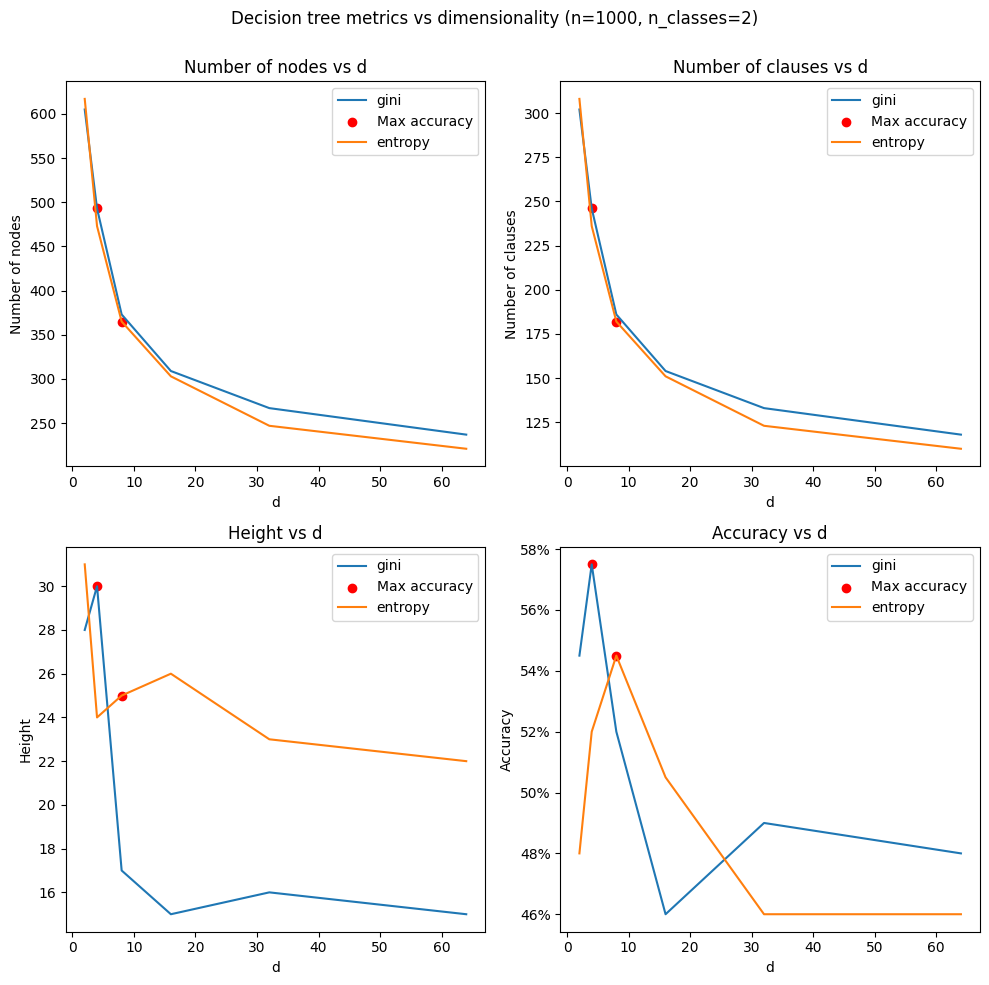

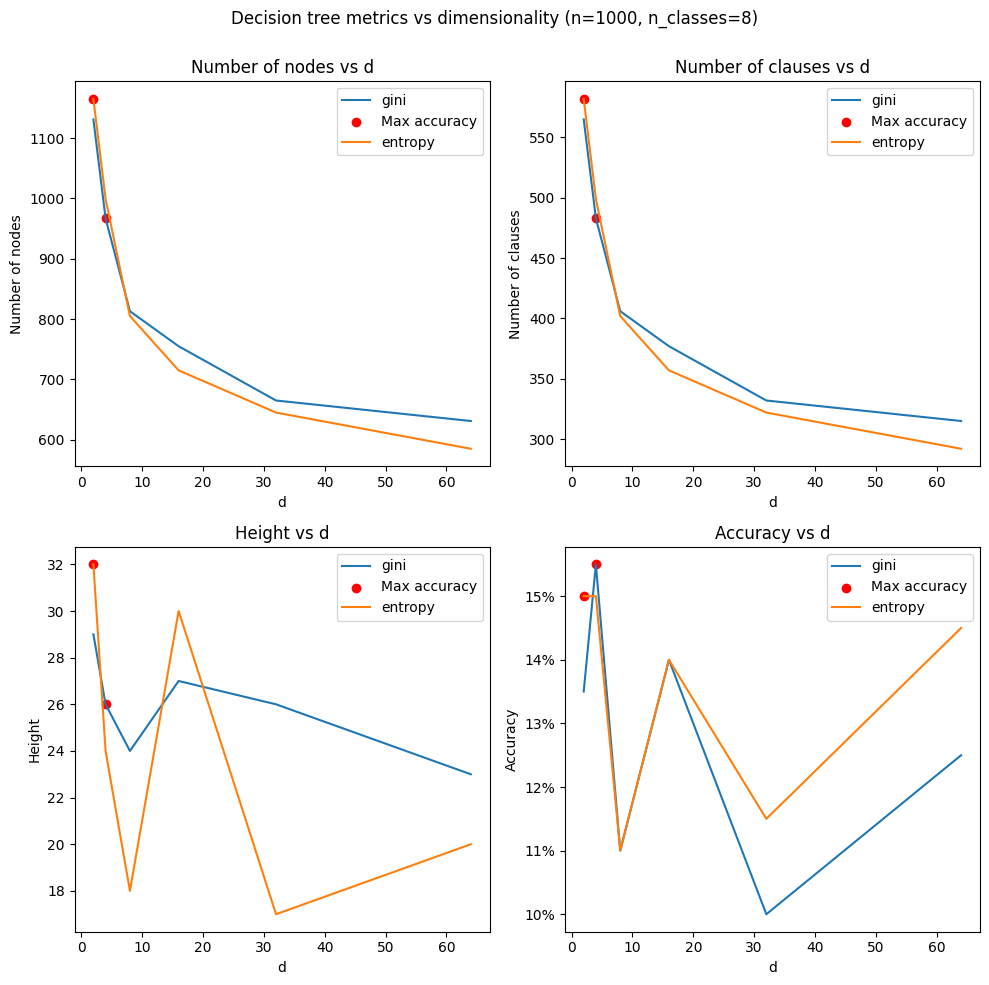

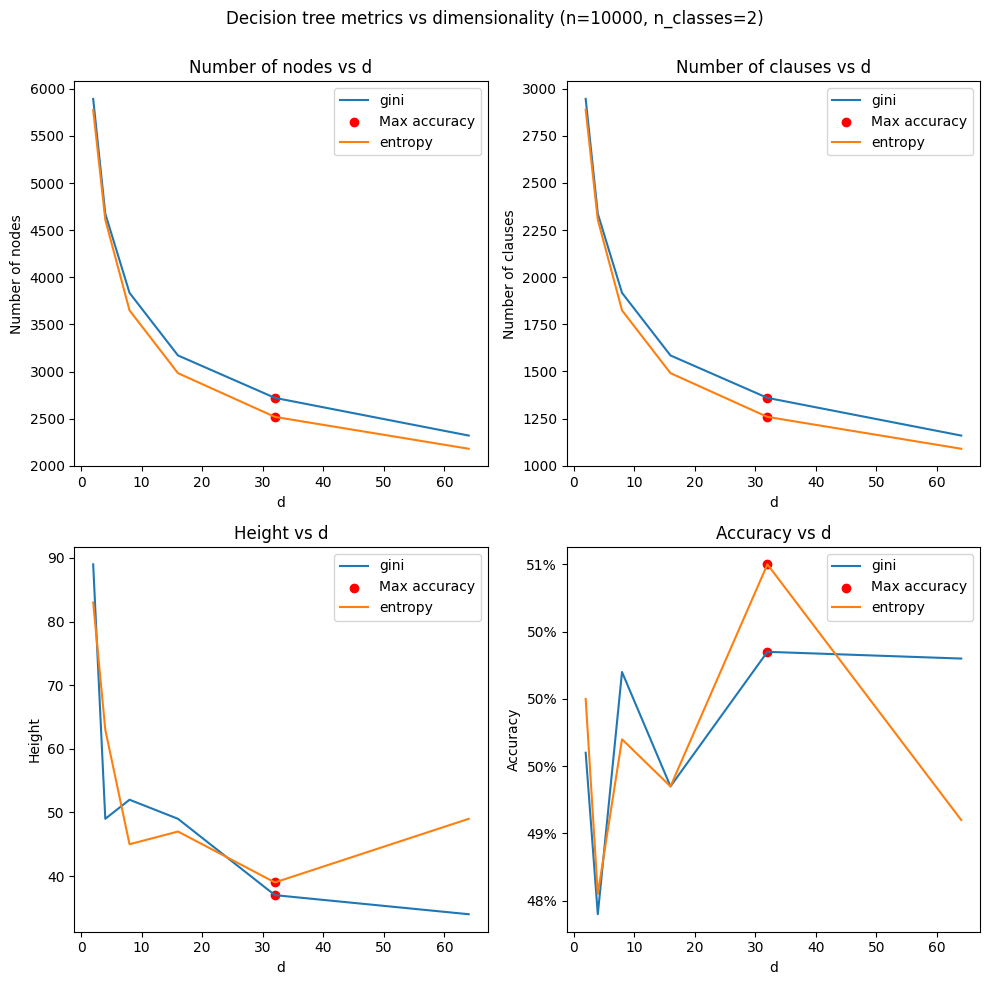

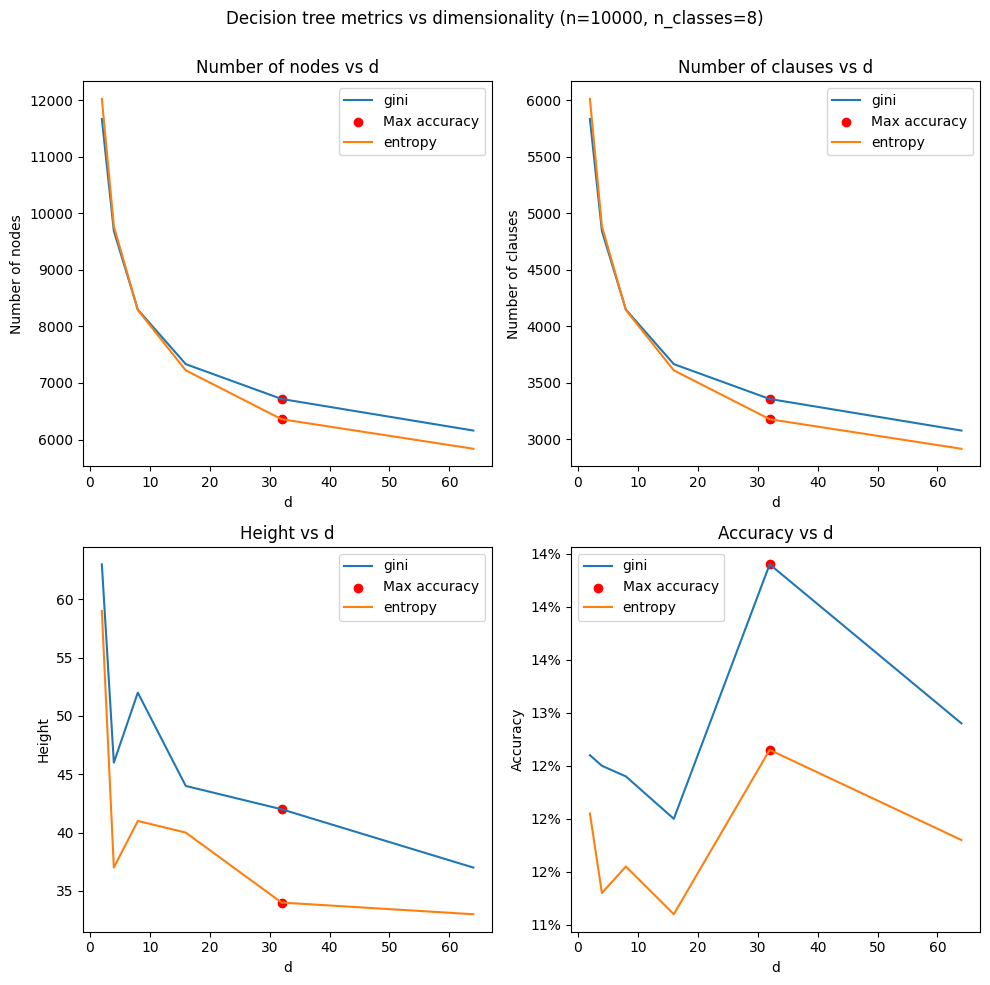

In [99]:
dimensions = [2, 4, 8, 16, 32, 64] # Data dimensionalities to test

for n in [1000, 10000]:
    for n_classes in [2, 8]:
        metrics = generate_tree(n, n_classes, dimensions)
        plot_metrics(metrics, n, n_classes)

The above figures show the various decision metrics for the decision trees fitted to 4 different configurations of {1000, 10000} datapoints of {2, 8} classes. Random datasets of dimensionality 2, 4, 8, 16, 32, and 64 are then generated and fitted to decision trees using both Gini impurity and Shannon entropy.

Unsurprisingly, the highest accuracy decision rules come from the $2$-class datasets. However, within these binary classification datasets, the highest accuracy dimensionality is much lower ($<10$) when the number of datapoints is $1000$ and much higher ($\approx 32$) when the number of datapoints is $10000$. The number of if-then clauses is also much lower in the $1000$-datapoint datasets, with approximately $10$ x fewer clauses than the $10000$-datapoint dataset at $\approx 175-250$ clauses.

Across all datasets, Shannon entrop consistently results in fewer if-then clauses. However, it also tends to result in a lower accuracy for then $8$-class datasets, appearing to favor the binary classification datasets.

# Exercise 6.3

Create a long random string using a Python program, and use a lossless compression algorithm of your choice to compress the string. Note the compression ratio.

In [14]:
# Create a long random string using a Python program, and use a lossless compression algorithm of your choice to compress the string. Note the compression ratio.

import zlib
import sys

s = ''.join([str(np.random.randint(0, 2)) for _ in range(10000)])

compressed = zlib.compress(s.encode('utf-8'))
print(f"Original size: {sys.getsizeof(s)}")
print(f"Compression ratio: {sys.getsizeof(s) / sys.getsizeof(compressed)}")

## Use sys.getsizeof to get the size of the string in memory, not the length of the string

Original size: 10041
Compression ratio: 5.906470588235294


In [17]:
def entropy(s):
    _, counts = np.unique(list(s), return_counts=True) # Get the unique characters and their counts
    p = counts / len(s)
    return -np.sum(p * np.log2(p))

def ideal_entropy(n):
    p = 1 / 2
    return -n * p * np.log2(p)

print(f"Shannon entropy of the string: {entropy(s)}")
print(f"Entropy of a truly random string of the same length: {ideal_entropy(len(s))}")

Shannon entropy of the string: 0.9999992786523593
Entropy of a truly random string of the same length: 5000.0


What is the expected compression ratio? Explain why.

Assuming we have a truly random bit generator - which we don't, and cannot have - then the entropy of each bit is $log_2(0.5) = -1$. Since the bits are truly independent, we cannot compress the string, yielding a theoretical compression ratio of 1. However, in practice, we can compress the string, since the bit generation is not truly random. The lower the entropy of the string, the higher the compression ratio. Hence, we see a compression ratio of slightly more than 1. 